In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import os


class Net(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128) # 定义第一个全连接层，输入为28*28=784个像素点，输出为128个特征图
        self.fc2 = torch.nn.Linear(128, 64) # 定义第二个全连接层，输入为128个特征图，输出为64个特征图
        self.fc3 = torch.nn.Linear(64, 10) # 定义第三个全连接层，输入为64个特征图，输出为10个分类
        self.dropout = torch.nn.Dropout(0.2) # 添加Dropout层，防止过拟合
    
    # 前向传播
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x)) # ReLU激活
        x = self.dropout(torch.nn.functional.relu(self.fc2(x))) # 添加Dropout层，防止过拟合
        x = torch.nn.functional.log_softmax(self.fc3(x), dim=1) # 输出为10个分类，使用log_softmax激活函数，使得输出为对数概率
        return x # 返回输出

def get_data_loader(is_train):
    to_tensor = transforms.Compose([transforms.ToTensor()])
    data_set = MNIST("", is_train, transform=to_tensor, download=True)
    return DataLoader(data_set, batch_size=15, shuffle=True)


def evaluate(test_data, net):
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        for (x, y) in test_data:
            outputs = net.forward(x.view(-1, 28 * 28))
            for i, output in enumerate(outputs):
                if torch.argmax(output) == y[i]:
                    n_correct += 1
                n_total += 1
    return n_correct / n_total


def main():
    train_data = get_data_loader(is_train=True)
    test_data = get_data_loader(is_train=False)
    net = Net().to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    accuracies = []  # 用于记录每个 epoch 的准确率

    for epoch in range(5):
        for (x, y) in train_data:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28 * 28))
            loss = torch.nn.functional.nll_loss(output, y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        accuracy = evaluate(test_data, net)
        accuracies.append(accuracy)
        print("epoch", epoch, "accuracy:", accuracy)
    
    torch.save(net.state_dict(), 'model.pth')

    # 绘制准确率曲线
    plt.plot(range(1, 6), accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

epoch 0 accuracy: 0.9598
epoch 1 accuracy: 0.9636
epoch 2 accuracy: 0.9736
epoch 3 accuracy: 0.9718
epoch 4 accuracy: 0.9742


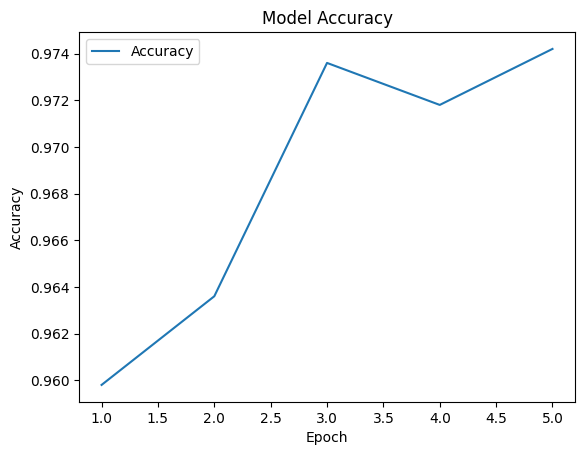

In [13]:
if __name__ == "__main__":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Device configuration
    main()
